In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pulp

In [178]:
def distribution_generator(breakpoints: list[tuple[int, int]],
                           reserve_range: list[int, int] = [900, 1000], 
                           plot: bool = True) -> list:
    """
    This function creates a linear distribution based on the introduced
    parameters, where x axis is the percentage of traders that accept to
    trade at the price in the y axis (following the convention in econ)

    Parameters:
    - breakpoints: coordinates of the breakpoints, where the slope of 
    the linear distribution changes

    - reserve_range: list with the minimum reserve price and max reserve
    price at the [0] and [1] respectively

    - plot: boolean value with default value True that if true, plots
    the generated distribution

    Returns: List with 2D numpy arrays, where each element is a segment
    of the distribution with a specific slope
    """
    slope_points = [(0, reserve_range[0])] + breakpoints + [(1, reserve_range[1])]
    segments = []

    for i in range(len(slope_points) - 1):
        slope = (slope_points[i+1][1] - slope_points[i][1]) /\
                (slope_points[i+1][0] - slope_points[i][0])
        intercept = slope_points[i][1] - slope * slope_points[i][0]
        x_segment = np.linspace(slope_points[i][0], slope_points[i+1][0],
                                num=int(10000), endpoint=False)
        y_segment = slope * x_segment + intercept
        segments.append(np.column_stack((x_segment, y_segment)))
    segments.append (np.array([[1, reserve_range[1]]]))
    segments.insert(0, np.array([[0, reserve_range[0]]]))
    if plot:
        plt.figure(figsize=(6, 8))
        for segment in segments:
            plt.plot(segment[:, 0], segment[:, 1])
        plt.title("Linear Distribution of Traders' Acceptance vs. Price")
        plt.xlabel("Percentage of Traders Accepting")
        plt.ylabel("Price")
        plt.grid(True)
        plt.show()

    distribution = np.vstack(segments)

    return distribution

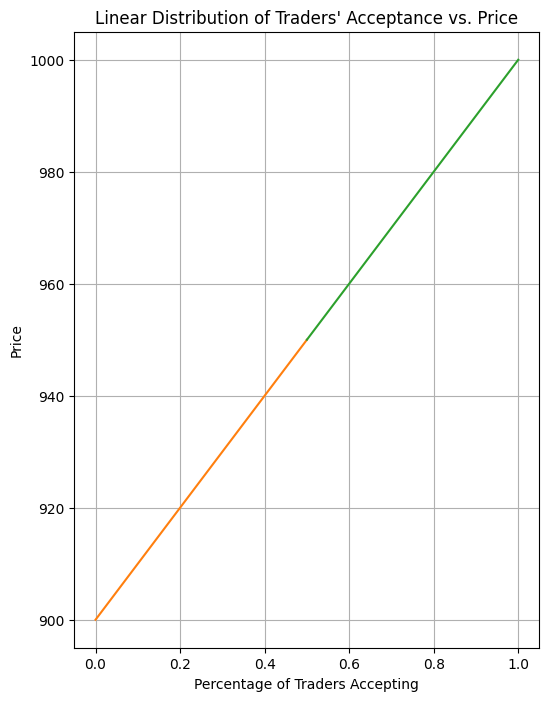

array([[0.00000e+00, 9.00000e+02],
       [0.00000e+00, 9.00000e+02],
       [5.00000e-05, 9.00005e+02],
       ...,
       [9.99900e-01, 9.99990e+02],
       [9.99950e-01, 9.99995e+02],
       [1.00000e+00, 1.00000e+03]])

In [179]:
distribution_generator([(0.5, 950)])

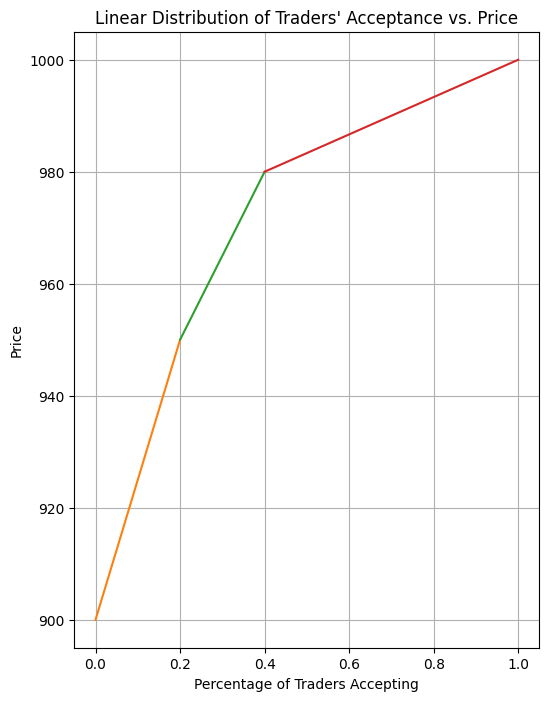

array([[0.00000e+00, 9.00000e+02],
       [0.00000e+00, 9.00000e+02],
       [2.00000e-05, 9.00005e+02],
       ...,
       [9.99880e-01, 9.99996e+02],
       [9.99940e-01, 9.99998e+02],
       [1.00000e+00, 1.00000e+03]])

In [180]:
distribution_generator([(0.2, 950), (0.4, 980)])

In [181]:
def distribution_plotter(**kwargs) -> None:
    """
    This function plots the inputed distributions together
    """
    plt.figure(figsize=(20, 10))
    
    for name, distribution in kwargs.items():
            plt.plot(distribution[:, 0], distribution[:, 1], label=name)

    plt.title("Comparison of Trader Acceptance Distributions")
    plt.xlabel("Percentage of Traders Accepting")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

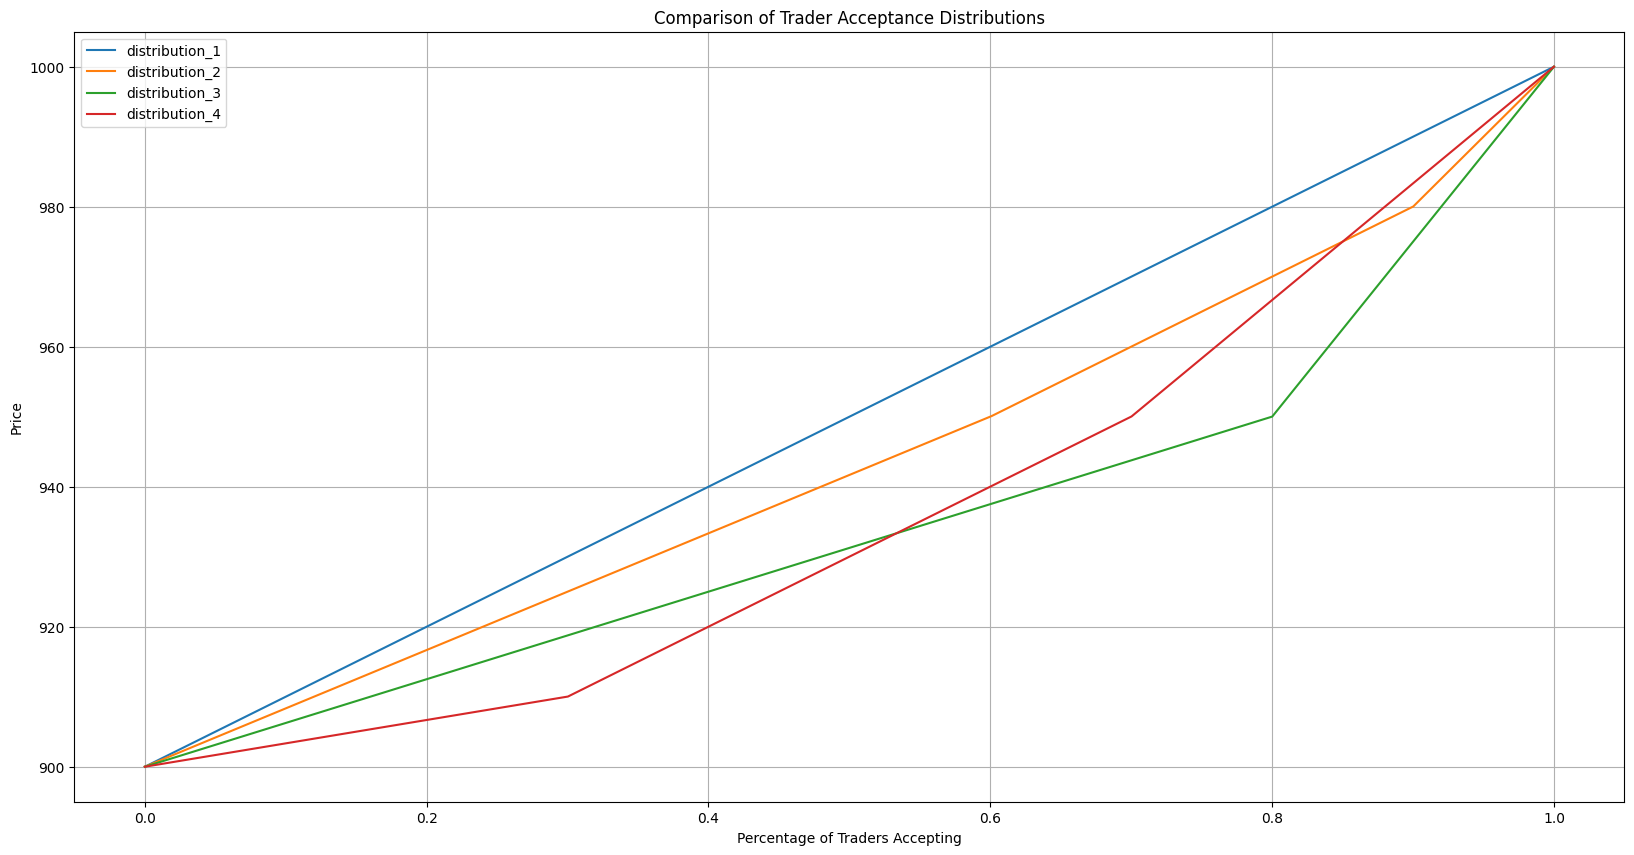

In [182]:
a = distribution_generator([(0.5, 950)], plot=False)
b = distribution_generator([(0.6, 950), (0.9, 980)], plot=False)
c = distribution_generator([(0.8, 950)], plot=False)
d = distribution_generator([(0.3, 910), (0.7, 950)], plot=False)
distribution_plotter(distribution_1 = a, distribution_2 = b, distribution_3 = c,
                     distribution_4 = d)

In [183]:
def profit_calculator(bids: list[int, int], distribution, q: int) -> float:
    """
    This function calculates the profit of the seller given a distribution
    of traders' acceptance and a range of bids

    Parameters:
    - bids: list with the lower bid at [0] and the higher bid at [1]
    - distribution: 2D numpy array with the distribution of traders' acceptance
    - q: quantity of trades
    
    Returns: float with the profit of the seller
    """
    profit = 0
    distribution[:, 1] = np.round(distribution[:, 1])
    try:
        low_bid, high_bid = bids
        acceptance_low = distribution[distribution[:, 1] == low_bid][:, 0][0]
        acceptance_high = distribution[(distribution[:, 1] > low_bid) &
                                       (distribution[:, 1] == high_bid)][:, 0][0] \
                                        - acceptance_low
        profit = q * acceptance_low * (1000 - low_bid) +\
                 q * acceptance_high * (1000 - high_bid)
    except:
        print(low_bid, high_bid)
        
    return profit

In [184]:
possible_bids = np.array([[low_bid, high_bid] for low_bid in range(900, 1000) for high_bid in range(low_bid+1, 1001)])

def bid_optimizer(distribution, q: int) -> list[int, int]:
    """
    This function optimizes the bids of the seller given a distribution
    of traders' acceptance and a quantity of trades

    Parameters:
    - distribution: 2D numpy array with the distribution of traders' acceptance
    - q: quantity of trades
    
    Returns: list with the lower bid at [0] and the higher bid at [1]
    """
    profits = np.array([profit_calculator(bid, distribution, q) for bid in possible_bids])
    best_bid = possible_bids[np.argmax(profits)]

    return best_bid, np.max(profits)

In [185]:
bid_optimizer(a, 100)

(array([934, 967]), 3300.165)

In [186]:
bid_optimizer(b, 100)

(array([933, 965]), 3855.7619999999997)

In [187]:
bid_optimizer(c, 100)

(array([926, 951]), 4949.898)

In [188]:
bid_optimizer(d, 100)

(array([916, 951]), 4687.347)